# Analyse des données MIMIC-III-Extract

Notebook en grande partie repris de https://github.com/MLforHealth/MIMIC_Extract. 

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
idx = pd.IndexSlice

# Confidentalité des données 

Ce notebook ne doit pas être publié en ligne sans masquer les cellules d'output.

# Un premier aperçu des données à travers un patient type

In [5]:
LEVEL2 = '/Users/linusbleistein/Documents/Thèse/data/mimic3_extract/all_hourly_data.h5'
X_level2 = pd.read_hdf(LEVEL2, 'vitals_labs')
X_mean_level2 = pd.read_hdf(LEVEL2, 'vitals_labs_mean')
Y_level2 = pd.read_hdf(LEVEL2, 'interventions')
S_level2 = pd.read_hdf(LEVEL2, 'patients')

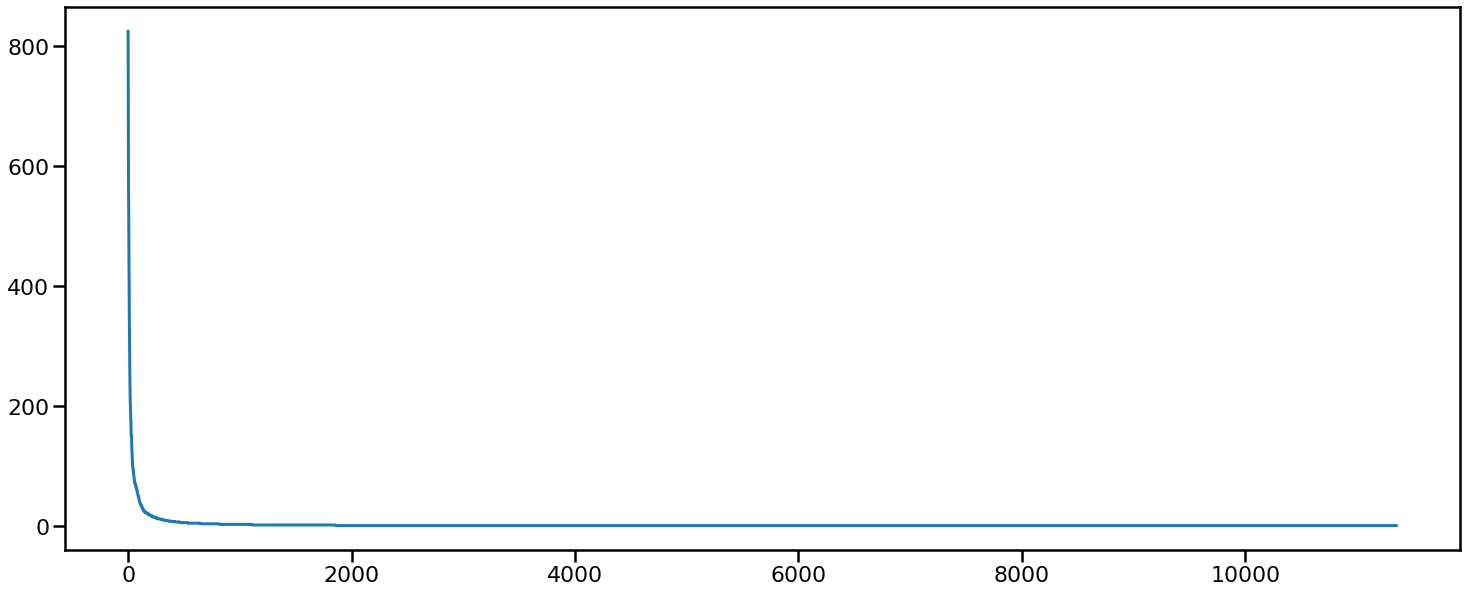

In [26]:
f,ax=plt.subplots(figsize=(25,10))
plt.plot(S_level2.loc[:,'diagnosis_at_admission'].value_counts().values)

Dans MIMIC-III-Extract, les données sont organisées dans 4 sous-dataframes différents: 
- *vital_labs* contient les signes vitaux des patients (il y en a 104 en tout !). Pour chaque signe, on dispose du nombre de mesures par heure, de la moyenne sur l'heure (toutes les données sont agrégées par heure) et de la variance. 
- *vital_labs_mean* contient les moyennes des signes vitaux. 
- *interventions* contient le recensement de toutes les interventions effectuées. 
- *patients* contient un résumé des information statiques pour chaque patient.

Le jeu de données utilise les [multi-indexes de pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), qui permettent de regrouper un ensemble de lignes ou de colonnes en une catégorie, i.e. d'indexer de manière hiérarchique. On peut sélectionner un élément d'un multi-indexe avec la commande *pd.IndexSlice*.

Prenons l'exemple du premier patient de la base de données. Ses informations principales sont stockées dans le dataframe 'patients'. 

In [6]:
#print(S_level2.columns)
print(S_level2.loc[3, ('gender', 'age', 'ethnicity', 'diagnosis_at_admission', 'deathtime', 'max_hours')])

                   gender        age ethnicity diagnosis_at_admission  \
hadm_id icustay_id                                                      
145834  211552          M  76.526792     WHITE            HYPOTENSION   

                   deathtime  max_hours  
hadm_id icustay_id                       
145834  211552           NaT        145  


Il s'agit d'un homme blanc, de 76 ans. Il a été admis à l'hôpital avec un diagnostic principal d'hypotension. Il n'est pas décédé et est resté 145 heures (11 jours) à l'hôpital. Dans la cellule suivante, les traitements marqués en __True__ sont ceux que le patient a reçu au moins une fois durant son séjour.

In [7]:
(Y_level2.loc[3] == 1).any()

vent                  True
vaso                  True
adenosine            False
dobutamine           False
dopamine              True
epinephrine          False
isuprel              False
milrinone            False
norepinephrine        True
phenylephrine         True
vasopressin          False
colloid_bolus        False
crystalloid_bolus     True
nivdurations          True
dtype: bool

La cellule suivante affiche toutes les constantes qui n'ont jamais été mesurées durant toute la durée du séjour. Sur les 104 constantes, 32 n'ont jamais été relevées pendant l'ensemble du séjour.

In [10]:
not_measured=(X_mean_level2.loc[3].isnull().values.all(axis=0) == True) 
X_mean_level2.loc[3, not_measured==True].columns

MultiIndex([(              'albumin ascites', 'mean'),
            (              'albumin pleural', 'mean'),
            (                'albumin urine', 'mean'),
            (                'calcium urine', 'mean'),
            (               'chloride urine', 'mean'),
            (                  'cholesterol', 'mean'),
            (              'cholesterol hdl', 'mean'),
            (              'cholesterol ldl', 'mean'),
            (           'creatinine ascites', 'mean'),
            (        'creatinine body fluid', 'mean'),
            (           'creatinine pleural', 'mean'),
            (             'creatinine urine', 'mean'),
            (                  'eosinophils', 'mean'),
            (     'fraction inspired oxygen', 'mean'),
            (                       'height', 'mean'),
            (        'lactate dehydrogenase', 'mean'),
            ('lactate dehydrogenase pleural', 'mean'),
            (          'lymphocytes ascites', 'mean'),
          

In [11]:
len(X_mean_level2.loc[3, not_measured==True].columns)

32

In [12]:
measured = (X_mean_level2.loc[3].isnull().values.all(axis=0) == False)
measured_data = X_mean_level2.loc[3, measured]

La cellule suivante montre le nombre de mesures par constante. On peut répartir les variables en trois groupes: certaines sont mesurées moins de 25 fois durant tout le séjour, soit moins d'une fois toutes les 6 heures (4 fois par jour), certaines sont mesures environ 75 fois (soit environ une fois toutes les deux heures) et quelques unes sont mesurées chaque heure.

No handles with labels found to put in legend.


Text(0, 0.5, '# de mesures effectuées')

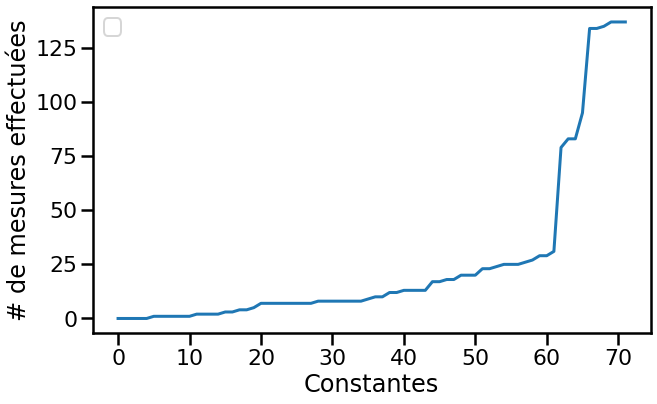

In [13]:
sns.set_context('poster')
count = np.sort(145-measured_data.isna().sum().values)
plt.figure(figsize=(10,6))
plt.plot(count)
plt.legend()
plt.xlabel('Constantes')
plt.ylabel('# de mesures effectuées')

La cellule suivante plot quelques unes de ses constantes et des médicaments reçus. 

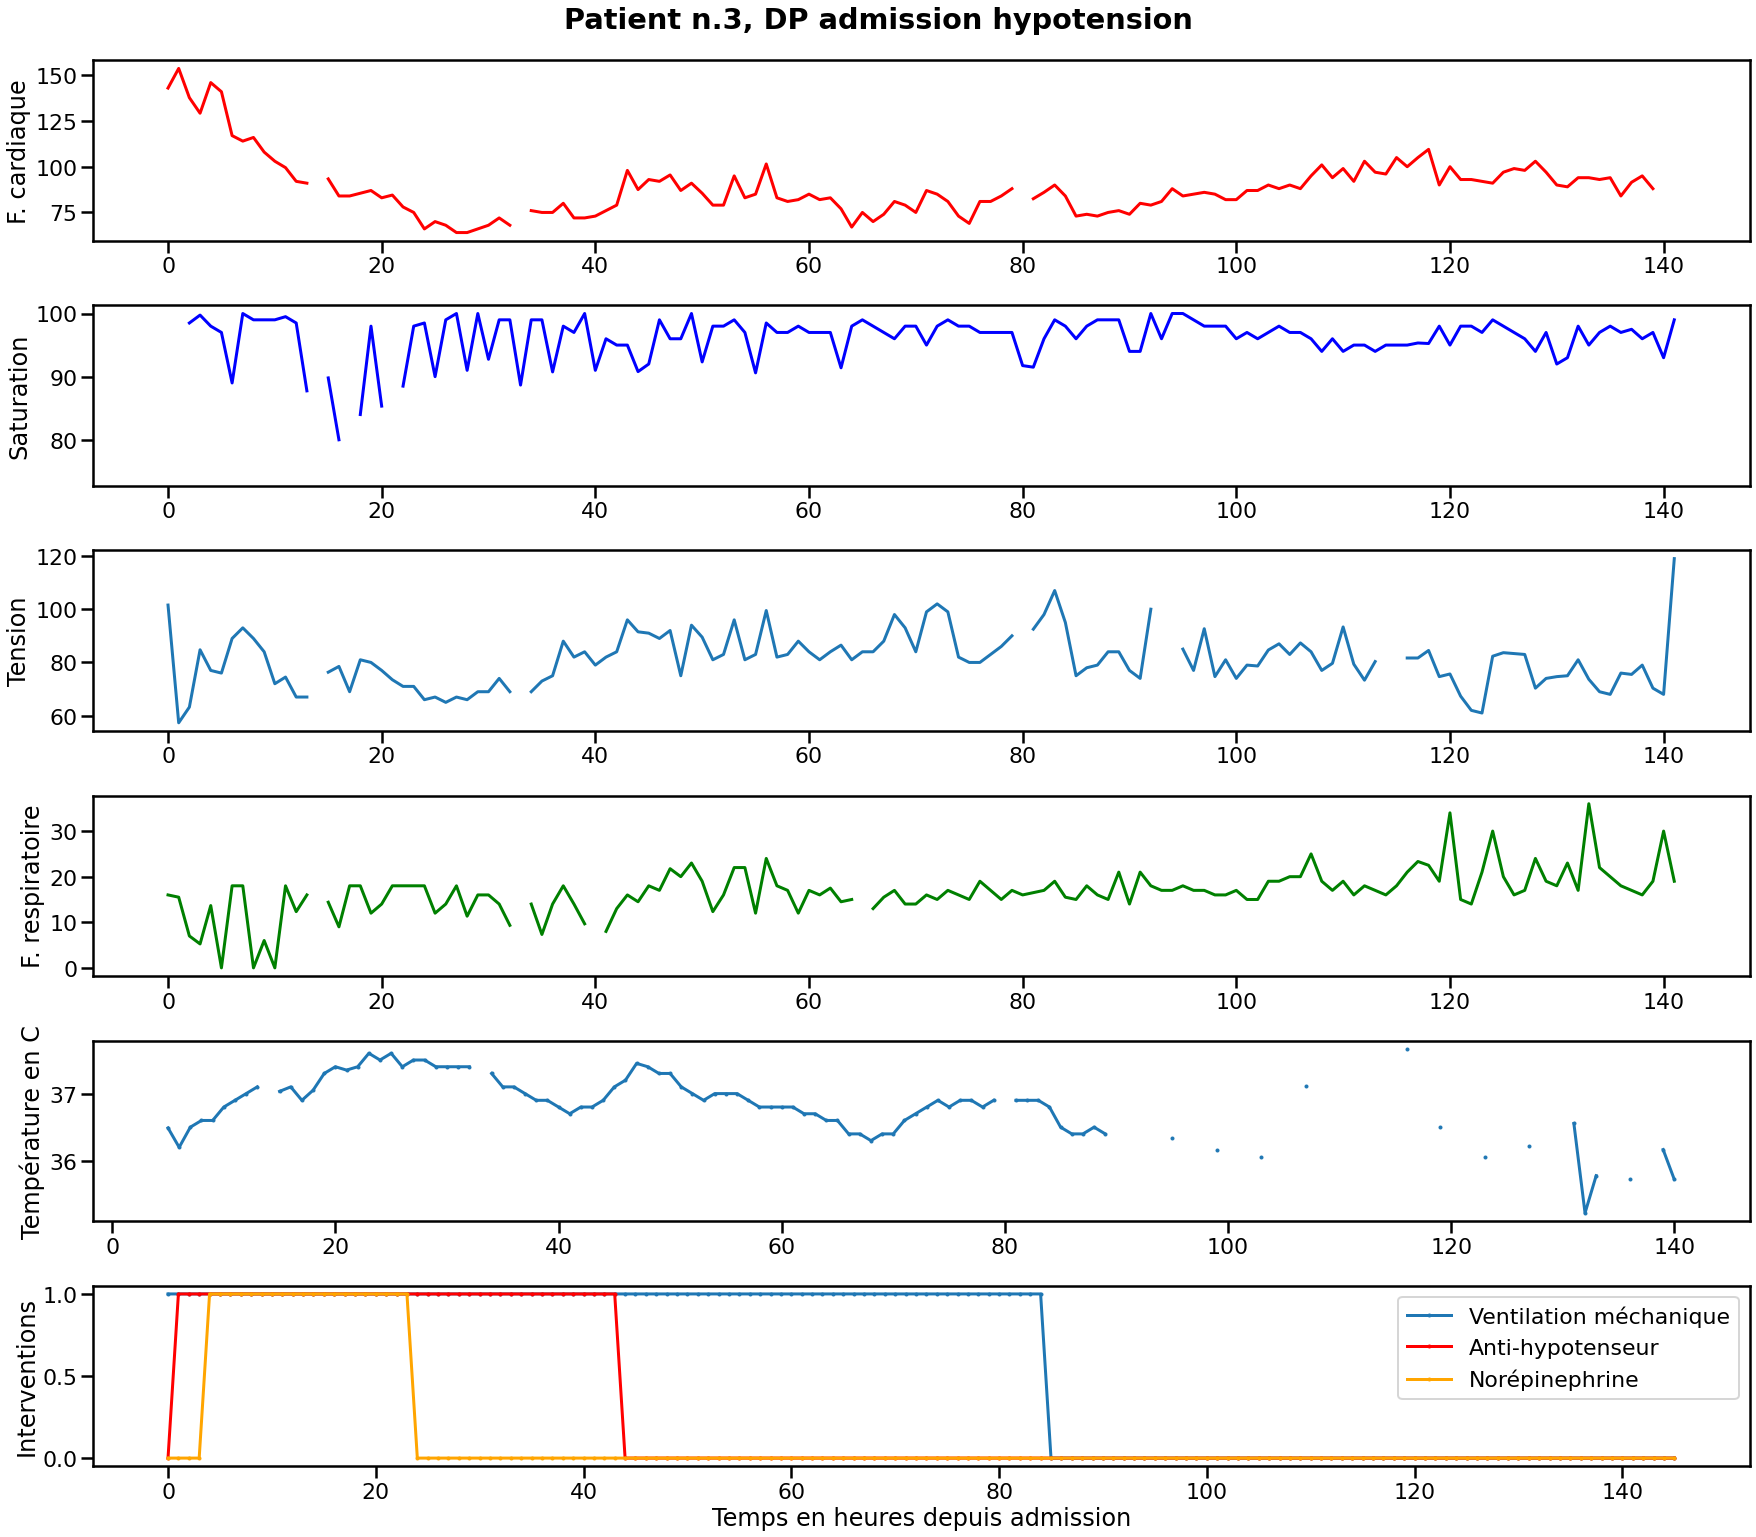

In [14]:
#Extraction des interventions
vent = Y_level2.loc[3,'vent']
vaso = Y_level2.loc[3,'vaso']
norepinephrine = Y_level2.loc[3,'norepinephrine']

#Extraction des signaux 
heart_rate = X_level2.loc[3,idx['heart rate','mean']]
sat = X_level2.loc[3,idx['oxygen saturation','mean']]
mbp = X_level2.loc[3,idx['mean blood pressure','mean']]
resp = X_level2.loc[3,idx['respiratory rate','mean']]
temp = X_level2.loc[3,idx['temperature','mean']]

sns.set_context('poster')

f,ax=plt.subplots(6,1,figsize=(25,22))

ax[0].plot(heart_rate.values,c='red')
ax[0].set_ylabel('F. cardiaque')
ax[1].plot(sat.values,c='blue')
ax[1].set_ylabel('Saturation')
ax[2].plot(mbp.values)
ax[2].set_ylabel('Tension')
ax[3].plot(resp.values,c='green')
ax[3].set_ylabel('F. respiratoire')
ax[4].plot(temp.values,marker='o',markersize=3)
ax[4].set_ylabel('Température en C')
ax[5].plot(vent.values, marker='o',markersize=3,label='Ventilation méchanique')
ax[5].plot(vaso.values, marker='o',c='red',markersize=3, label='Anti-hypotenseur')
ax[5].plot(norepinephrine.values, marker='o',c='orange',markersize=3, label='Norépinephrine')
ax[5].set_ylabel('Interventions')
ax[5].set_xlabel('Temps en heures depuis admission')
ax[5].legend()

plt.suptitle('Patient n.3, DP admission hypotension',fontweight='bold')
f.tight_layout(pad=1.2)
plt.show()


# Statistiques descriptives des patients

In [45]:
def categorize_age(age):
    if age > 10 and age <= 30: 
        cat = '<31'
    elif age > 30 and age <= 50:
        cat = '31-50'
    elif age > 50 and age <= 70:
        cat = '51-70'
    else: 
        cat = '>70'
    return cat
def categorize_ethnicity(ethnicity):
    if 'ASIAN' in ethnicity:
        ethnicity = 'ASIAN'
    elif 'WHITE' in ethnicity:
        ethnicity = 'WHITE'
    elif 'HISPANIC' in ethnicity:
        ethnicity = 'HISPANIC/LATINO'
    elif 'BLACK' in ethnicity:
        ethnicity = 'BLACK'
    else: 
        ethnicity = 'OTHER'
    return ethnicity

In [47]:
by_ethnicity = S_level2.reset_index().pivot_table(index='ethnicity',
                                                  columns='gender',
                                                  values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                                  aggfunc={'icustay_id': 'count',
                                                           'mort_icu': 'mean',
                                                           'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                                  margins=True)
by_ethnicity = by_ethnicity.sort_values(by=('icustay_id','All'))
by_ethnicity = pd.concat([by_ethnicity], keys=['ethnicity'], names=['item'])

by_insurance = S_level2.reset_index().pivot_table(index='insurance',
                                                  columns='gender',
                                                  values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                                  aggfunc={'icustay_id': 'count',
                                                           'mort_icu': 'mean',
                                                           'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                                  margins=True)
by_insurance = by_insurance.sort_values(by=('icustay_id','All'))
by_insurance = pd.concat([by_insurance], keys=['insurance'], names=['item'])

by_age = S_level2.reset_index().pivot_table(index='age_bucket',
                                            columns='gender',
                                            values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                            aggfunc={'icustay_id': 'count',
                                                     'mort_icu': 'mean',
                                                     'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                            margins=True)
by_age = by_age.sort_values(by=('icustay_id','All'))
by_age = pd.concat([by_age], keys=['age'], names=['item'])

by_admission = S_level2.reset_index().pivot_table(index='admission_type',
                                                  columns='gender',
                                                  values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                                  aggfunc={'icustay_id': 'count',
                                                           'mort_icu': 'mean',
                                                           'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                                  margins=True)
by_admission = by_admission.sort_values(by=('icustay_id','All'))
by_admission = pd.concat([by_admission], keys=['admission_type'], names=['item'])

by_unit = S_level2.reset_index().pivot_table(index='first_careunit',
                                              columns='gender',
                                              values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                              aggfunc={'icustay_id': 'count',
                                                       'mort_icu': 'mean',
                                                       'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                              margins=True)
by_unit = by_unit.sort_values(by=('icustay_id','All'))
by_unit = pd.concat([by_unit], keys=['first_careunit'], names=['item'])

In [48]:
demographics = pd.concat([by_ethnicity, by_age, by_insurance, by_admission, by_unit],axis=0)
demographics.index.names = ['item','values']
demographics

icustay_id                max_hours             \
gender                                  F      M    All          F          M   
item           values                                                           
ethnicity      ASIAN                  370    472    842  62.227027  63.665254   
               HISPANIC/LATINO        448    689   1137  59.399554  59.854862   
               BLACK                 1448   1219   2667  61.247928  60.150123   
               OTHER                 2061   3122   5183  69.355167  65.557976   
               WHITE                10651  13992  24643  63.180640  61.677887   
               All                  14978  19494  34472  63.706770  62.187442   
age            <31                    748   1084   1832  54.633690  57.380996   
               31-50                 2212   3277   5489  58.920434  58.191028   
               51-70                 4888   8050  12938  63.571399  61.121615   
               >70                   7130   7083  14213  66.236325  65.983340   
               All                  14978  19494  34472  63.706770  62.187442   
insurance      Self Pay               125    352    477  51.832000  54.272727   
               Government             402    648   1050  58.393035  61.504630   
               Medicaid              1186   1596   2782  61.787521  61.651003   
               Private               4415   7431  11846  60.354700  58.865832   
               Medicare              8850   9467  18317  66.045311  65.226154   
               All                  14978  19494  34472  63.706770  62.187442   
admission_type URGENT                 409    528    937  69.383863  66.710227   
               ELECTIVE              2282   3423   5705  58.380368  54.498101   
               EMERGENCY            12287  15543  27830  64.507040  63.727208   
               All                  14978  19494  34472  63.706770  62.187442   
first_careunit TSICU                 1777   2725   4502  61.366348  64.075963   
               CCU                   2185   3008   5193  64.816934  63.652593   
               SICU                  2678   2842   5520  66.326736  65.376144   
               CSRU                  2326   4724   7050  65.334050  57.824090   
               MICU                  6012   6195  12207  62.198436  62.509766   
               All                  14978  19494  34472  63.706770  62.187442   

                                          mort_hosp                      \
gender                                All         F         M       All   
item           values                                                     
ethnicity      ASIAN            63.033254  0.100000  0.095339  0.097387   
               HISPANIC/LATINO  59.675462  0.064732  0.059507  0.061566   
               BLACK            60.746157  0.069061  0.067268  0.068241   
               OTHER            67.067914  0.159631  0.118193  0.134671   
               WHITE            62.327395  0.102526  0.084334  0.092197   
               All              62.847586  0.105955  0.088078  0.095846   
age            <31              56.259279  0.025401  0.042435  0.035480   
               31-50            58.484970  0.057414  0.052487  0.054473   
               51-70            62.047148  0.082242  0.072547  0.076210   
               >70              66.110251  0.145722  0.129183  0.137480   
               All              62.847586  0.105955  0.088078  0.095846   
insurance      Self Pay         53.633124  0.144000  0.107955  0.117400   
               Government       60.313333  0.032338  0.055556  0.046667   
               Medicaid         61.709202  0.075042  0.077694  0.076564   
               Private          59.420733  0.069083  0.060153  0.063481   
               Medicare         65.621936  0.131299  0.113235  0.121963   
               All              62.847586  0.105955  0.088078  0.095846   
admission_type URGENT           67.877268  0.117359  0.100379  0.107791   
               ELECTIVE  

Text(0, 0.5, '# de patients')

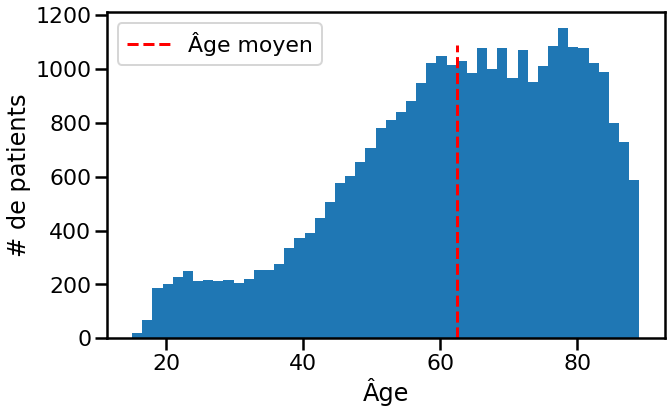

In [15]:
age = S_level2['age']
age = age[age<300]
plt.figure(figsize=(10,6))
plt.hist(age, bins=50)
plt.axvline(x=age.mean(), ymin=0, ymax=0.9, c='red',linestyle='--',label='Âge moyen')
plt.legend()
plt.xlabel('Âge')
plt.ylabel('# de patients')

Text(0, 0.5, '# de patients')

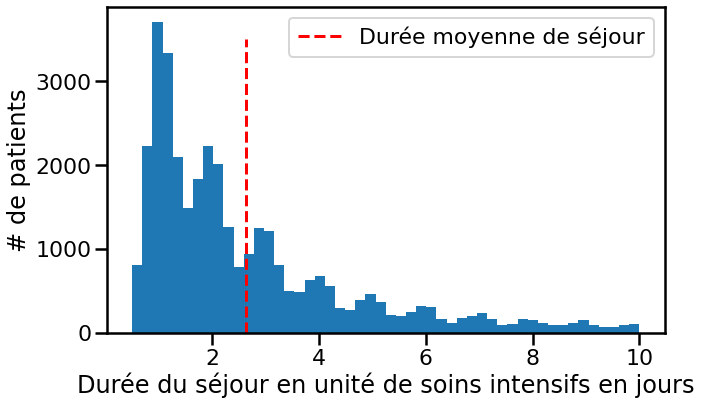

In [96]:
los = S_level2['los_icu']
plt.figure(figsize=(10,6))
plt.hist(los, bins=50)
plt.axvline(x=los.mean(), ymin=0, ymax=0.9, c='red',linestyle='--',label='Durée moyenne de séjour')
plt.legend()
plt.xlabel('Durée du séjour en unité de soins intensifs en jours')
plt.ylabel('# de patients')

# Statistiques descriptives sur les constantes et les interventions

In [94]:
vitals_mean = pd.DataFrame(X_mean_level2.mean(),columns=['mean'])
vitals_std = pd.DataFrame(X_mean_level2.std(),columns=['stdev'])
vitals_missing = pd.DataFrame(X_mean_level2.isnull().sum()/X_mean_level2.shape[0]*100,columns=['missing percent'])

vitals_summary = pd.concat([vitals_mean,vitals_std,vitals_missing],axis=1)
vitals_summary.index = vitals_summary.index.droplevel(1)
vitals_summary.sort_values(by='missing percent', ascending=True,inplace=True)
vitals_summary

,mean,stdev,missing percent
LEVEL2,,,
heart rate,84.974313,17.271791,10.413939
respiratory rate,19.093328,5.722042,11.835777
systolic blood pressure,121.828655,21.994139,13.258342
diastolic blood pressure,60.891112,14.128354,13.279696
mean blood pressure,79.371499,15.486783,13.712145
...,...,...,...
albumin ascites,1.707018,0.809755,99.994820
creatinine ascites,3.471094,7.165170,99.997092
lymphocytes atypical csl,2.678571,4.450023,99.998092


La cellule suivante montre le pourcentage de valeurs manquantes par constante. Le taux est calculé par rapport à l'ensemble des temps de mesures (il y en a donc patients * somme des temps de séjours en heures). 

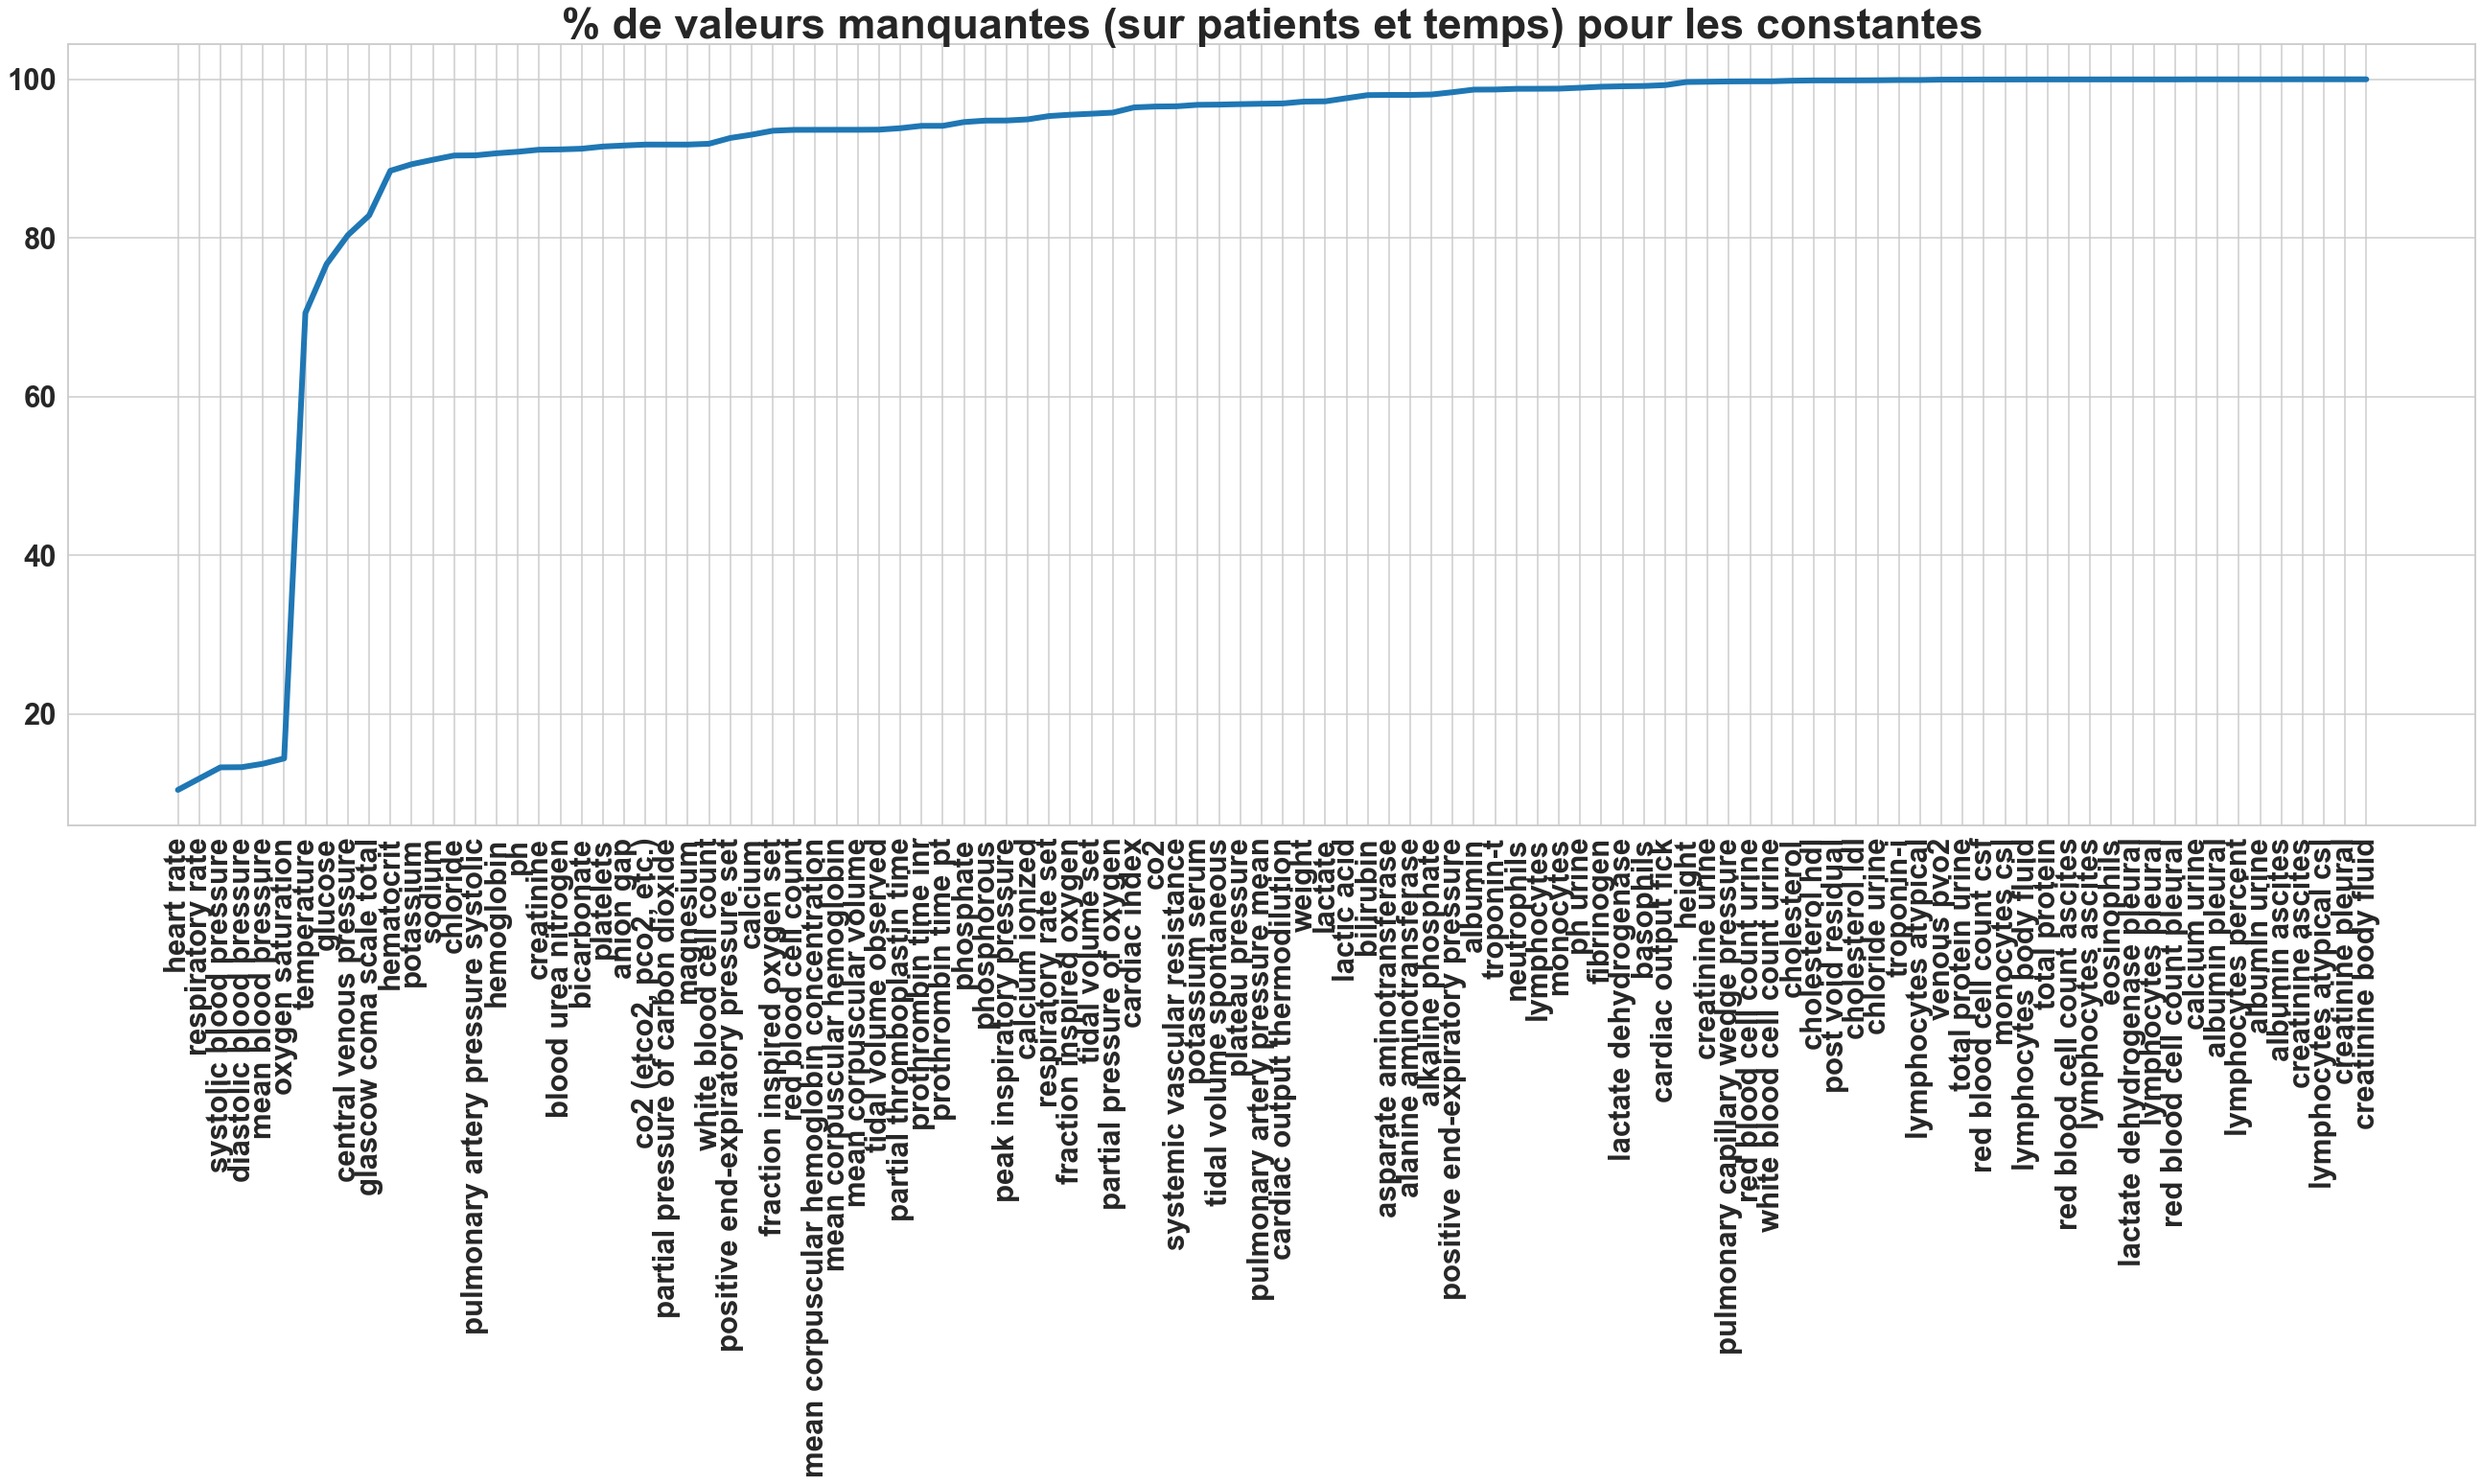

In [111]:
sns.set_context('talk')
sns.set_style('whitegrid')
f,ax=plt.subplots(figsize=(45,15))
plt.xticks(rotation=90,fontweight='bold',fontsize='xx-large')
plt.yticks(fontweight='bold',fontsize='xx-large')
plt.title('% de valeurs manquantes (sur patients et temps) pour les constantes',fontsize=45,fontweight='bold')
plt.plot(vitals_summary['missing percent'].index,vitals_summary['missing percent'].values,linewidth=6)

## Interventions

In [115]:
mean_duration = pd.DataFrame(Y_level2.reset_index().groupby('icustay_id').agg(sum).mean()[3:],columns=['hours'])

In [116]:
mean_duration

,hours
vent,12.200743
vaso,8.099124
adenosine,0.001508
dobutamine,0.356782
dopamine,0.948364
epinephrine,0.598399
isuprel,0.005483
milrinone,0.871838
norepinephrine,2.720933
phenylephrine,4.055697


__Vaso__ est une variable qui vaut 1 si un patient reçoit au moins un traitements vasopresseur (anti-hypotenseur). Les vasopresseurs sont ensuite déclinés en 9 traitements possibles.  